## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #For displaying all the columns of dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
import pickle

In [2]:
!pip install openpyxl -q 

## Helper Functions

In [3]:
def extract_date_hour(dataset, col): 
    dataset[col + '_hour'] = dataset[col].dt.hour
    dataset[col + '_minute'] = dataset[col].dt.minute
    dataset.drop(col, axis=1, inplace=True)
    
    return dataset

## Loading Dataset

In [4]:
df = pd.read_excel('../input/flight-price/Data_Train.xlsx')
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662


## Exploratory Data Analysis | Feature Engineering

In [5]:
df.isnull().sum().sum()

2

#### As the Nan values are less, so dropping it.

In [6]:
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


### Working with Datetime columns
#### As the columns are of object type, converting them to datetime.

In [8]:
# Changing the datatype from object to datetime. 
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['Dep_Time']        = pd.to_datetime(df['Dep_Time'])
df['Arrival_Time']    = pd.to_datetime(df['Arrival_Time'])


#Extracting Day and Month.
df['Day']   = df['Date_of_Journey'].dt.day
df['Month'] = df['Date_of_Journey'].dt.month
df.drop('Date_of_Journey', axis=1, inplace=True)


#Extracting Hour and Minute.
df = extract_date_hour(df, 'Arrival_Time')
df = extract_date_hour(df, 'Dep_Time')

In [9]:
df.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,1,10,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,13,15,5,50


### Cleaning the 'Duration' column

In [10]:
duration = list(df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' ')) == 2:
        pass
    else:
        if 'h' in duration[i]:
            duration[i]=duration[i] + ' 0m'
        else:
            duration[i]='0h '+ duration[i]

df['Duration'] = duration

In [11]:
df['Hour']   = df['Duration'].apply(lambda x:x.split(' ')[0][0:-1]).astype('int32')
df['Minute'] = df['Duration'].apply(lambda x:x.split(' ')[1][0:-1]).astype('int32')
df.drop('Duration', axis=1, inplace=True)

### Working with Categorical Columns

In [12]:
cat = [i for i in df.columns if df[i].dtype == 'O']
cat

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

### Working with Airlines columns

In [13]:
px.pie(data_frame=df, values=df['Airline'].value_counts(),
       names=df['Airline'].value_counts().index, hole=0.55)

In [14]:
px.histogram(data_frame=df, x='Airline', y='Price')

In [15]:
px.box(data_frame=df.sort_values('Price',ascending=False), x='Airline', y='Price')

#### Clearly, Jet Airway has the maximum price range.

### Working with Total_Stops

In [16]:
px.histogram(data_frame=df, x='Total_Stops', y='Price', width=600, height=400)

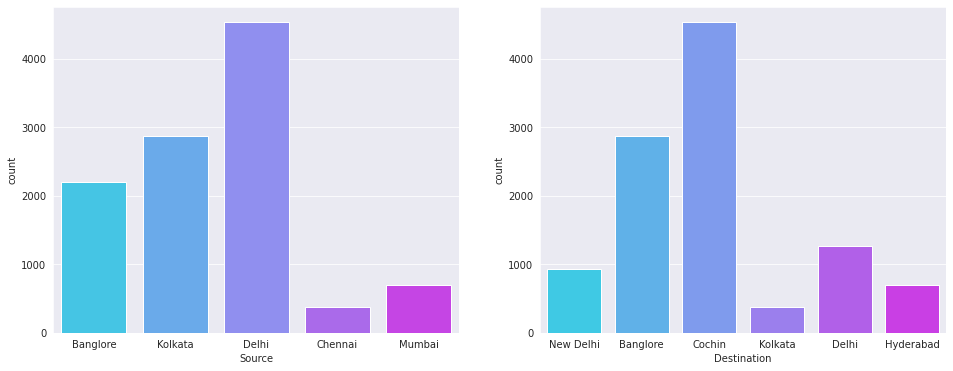

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(df['Source'], palette='cool', ax=ax[0])
sns.countplot(df['Destination'], palette='cool', ax=ax[1])
plt.show()

### Cleaning the 'Route' column

In [18]:
df['Route_1']=df['Route'].str.split('→').str[0]
df['Route_2']=df['Route'].str.split('→').str[1]
df['Route_3']=df['Route'].str.split('→').str[2]
df['Route_4']=df['Route'].str.split('→').str[3]
df['Route_5']=df['Route'].str.split('→').str[4]


df['Route_1'].fillna('None',inplace=True)
df['Route_2'].fillna('None',inplace=True)
df['Route_3'].fillna('None',inplace=True)
df['Route_4'].fillna('None',inplace=True)
df['Route_5'].fillna('None',inplace=True)

In [19]:
df['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

#### Clearly, this column mostly contains No info, so it is of no use.

## Encoding categorical data

In [20]:
df[cat].head(3)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info


In [21]:
airline = pd.get_dummies(df['Airline'])
t_stops = pd.get_dummies(df['Total_Stops'])

In [22]:
Destination=df[['Destination']]
Destination=pd.get_dummies(Destination, drop_first=True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [23]:
Source=df[['Source']]
Source=pd.get_dummies(Source, drop_first=True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [24]:
label = LabelEncoder()
for i in ["Route_1","Route_2","Route_3","Route_4","Route_5"]:
    df[i] = label.fit_transform(df[i])
    

## Dropping unnesessary columns

In [25]:
df.drop(['Airline', 'Source', 'Destination', 'Route', 'Additional_Info', 'Total_Stops'],
       axis=1, inplace=True)

## Merging the cleaned Dataset

In [26]:
data = pd.concat([df, airline, Source, Destination, t_stops], axis=1)
data.head(2)

,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute,Hour,Minute,Route_1,Route_2,Route_3,Route_4,Route_5,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,1 stop,2 stops,3 stops,4 stops,non-stop
0,3897,24,3,1,10,22,20,2,50,0,13,29,13,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,7662,5,1,13,15,5,50,7,25,2,25,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


## Outliers Detection

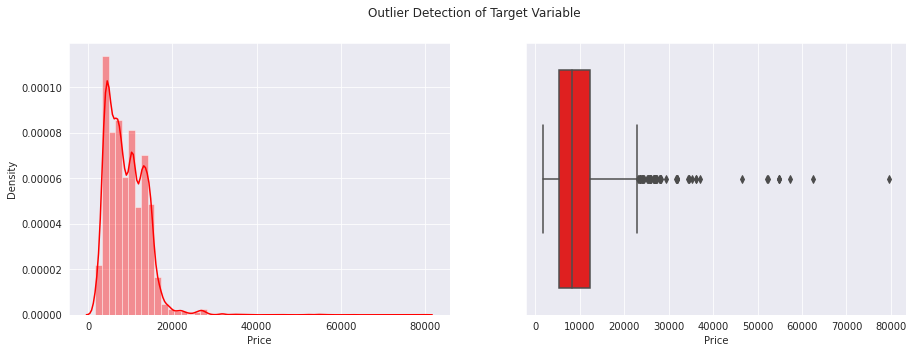

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(data['Price'], color='r', ax=ax[0])
sns.boxplot (data['Price'], color='r', ax=ax[1])
plt.suptitle('Outlier Detection of Target Variable')
fig.show()

In [28]:
data['Price'] = data['Price'].apply(lambda x:df['Price'].median() if x > 40000 else x)

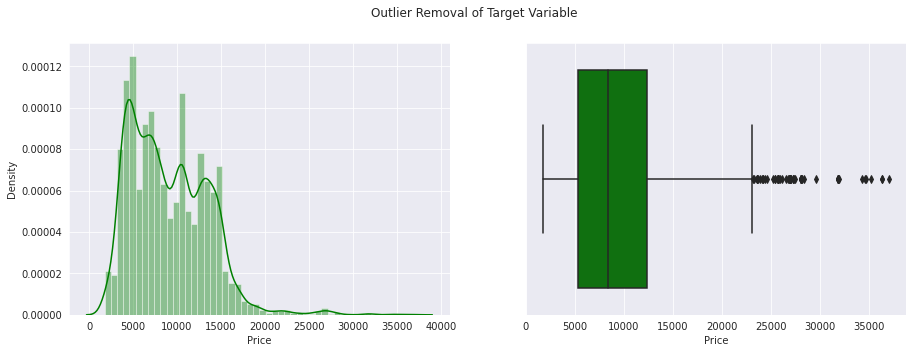

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(data['Price'], color='g', ax=ax[0])
sns.boxplot (data['Price'], color='g', ax=ax[1])
plt.suptitle('Outlier Removal of Target Variable')
fig.show()

#### Clearly, the outliers have been removed but, the distribution is still not looking good. Therefore let's see what happens if we perform Log Transformation

The logarithm, x to log base 10 of x, or x to log base e of x (ln x), or x to log base 2 of x, is a strong transformation with a major effect on distribution shape. It is commonly used for reducing right skewness and is often appropriate for measured variables. It can not be applied to zero or negative values. One unit on a logarithmic scale means a multiplication by the base of logarithms being used.

In [30]:
data['Price'] = np.log(data['Price'])

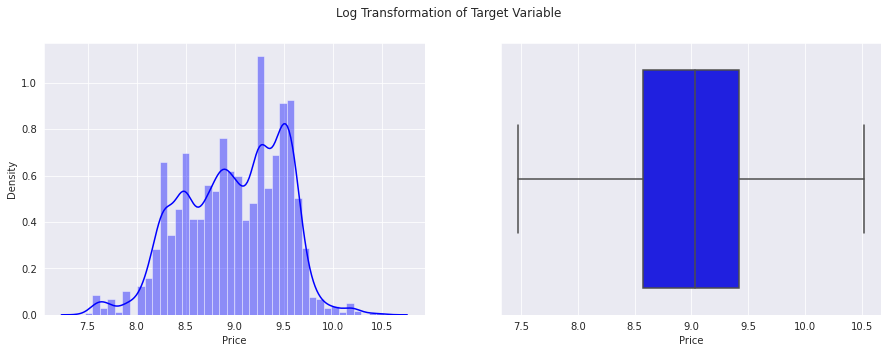

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(data['Price'], color='b', ax=ax[0])
sns.boxplot (data['Price'], color='b', ax=ax[1])
plt.suptitle('Log Transformation of Target Variable')
fig.show()

In [32]:
data.drop(['Trujet'],axis=1, inplace=True)

## Similar operations on the testing dataset so that the model can work efficiently

In [33]:
test_data=pd.read_excel('../input/flight-price/Test_set.xlsx')
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [35]:
test_data.dropna(inplace=True)
test_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [36]:
data.head()

,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute,Hour,Minute,Route_1,Route_2,Route_3,Route_4,Route_5,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,1 stop,2 stops,3 stops,4 stops,non-stop
0,8.267962,24,3,1,10,22,20,2,50,0,13,29,13,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,8.944028,5,1,13,15,5,50,7,25,2,25,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,9.538348,6,9,4,25,9,25,19,0,3,32,4,5,5,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
3,8.735204,5,12,23,30,18,5,5,25,2,34,3,13,5,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,9.495670,3,1,21,35,16,50,4,45,0,34,8,13,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [37]:
#Complete data preprocessing

# Date_of_Journey
test_data["Day"] = pd.to_datetime(test_data.Date_of_Journey, format="%d/%m/%Y").dt.day
test_data["Month"] = pd.to_datetime(test_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

# Dep_Time
test_data["Dep_Time_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_Time_minute"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

# Arrival_Time
test_data["Arrival_Time_hour"] = pd.to_datetime(test_data.Arrival_Time).dt.hour
test_data["Arrival_Time_minute"] = pd.to_datetime(test_data.Arrival_Time).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

# Duration
duration = list(test_data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_data["Hour"] = duration_hours
test_data["Minute"] = duration_mins
test_data.drop(["Duration"], axis = 1, inplace = True)

In [38]:
test_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Day,Month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Hour,Minute
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,6,6,17,30,4,25,10,55
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,1 stop,No info,12,5,6,20,10,20,4,0
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,In-flight meal not included,21,5,19,15,19,0,23,45
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,21,5,8,0,21,0,13,0
4,Air Asia,Banglore,Delhi,BLR → DEL,non-stop,No info,24,6,23,55,2,45,2,50


### Handling categorical data

In [39]:
airline = pd.get_dummies(test_data['Airline'])
t_stops = pd.get_dummies(test_data['Total_Stops'])

In [40]:
Destination=test_data[['Destination']]
Destination=pd.get_dummies(Destination, drop_first=True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,0,0,0,0
1,0,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [41]:
Source=test_data[['Source']]
Source=pd.get_dummies(Source, drop_first=True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,0


In [42]:
test_data['Route_1']=test_data['Route'].str.split('→').str[0]
test_data['Route_2']=test_data['Route'].str.split('→').str[1]
test_data['Route_3']=test_data['Route'].str.split('→').str[2]
test_data['Route_4']=test_data['Route'].str.split('→').str[3]
test_data['Route_5']=test_data['Route'].str.split('→').str[4]


test_data['Route_1'].fillna('None',inplace=True)
test_data['Route_2'].fillna('None',inplace=True)
test_data['Route_3'].fillna('None',inplace=True)
test_data['Route_4'].fillna('None',inplace=True)
test_data['Route_5'].fillna('None',inplace=True)

In [43]:
label = LabelEncoder()
for i in ["Route_1","Route_2","Route_3","Route_4","Route_5"]:
    test_data[i] = label.fit_transform(test_data[i])

In [44]:
test_data.drop(['Airline', 'Source', 'Destination', 'Route', 'Additional_Info', 'Total_Stops'],
       axis=1, inplace=True)

In [45]:
test = pd.concat([test_data, airline, Source, Destination, t_stops], axis=1)

## Feature Selection

In [46]:
x = data.loc[:, ['Day', 'Month','Arrival_Time_hour', 'Arrival_Time_minute', 'Dep_Time_hour', 'Dep_Time_minute',
        'Hour', 'Minute',
       'Route_1', 'Route_2', 'Route_3', 'Route_4','Route_5',
       'Air Asia','Air India','GoAir', 'IndiGo','Jet Airways',
       'Jet Airways Business', 'Multiple carriers','Multiple carriers Premium economy', 'SpiceJet', 'Vistara', 'Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin','Destination_Delhi','Destination_Hyderabad','Destination_Kolkata','Destination_New Delhi',
       '1 stop','2 stops','3 stops','4 stops','non-stop']]

In [47]:
y=data.iloc[:, 0]
y.head()

0    8.267962
1    8.944028
2    9.538348
3    8.735204
4    9.495670
Name: Price, dtype: float64

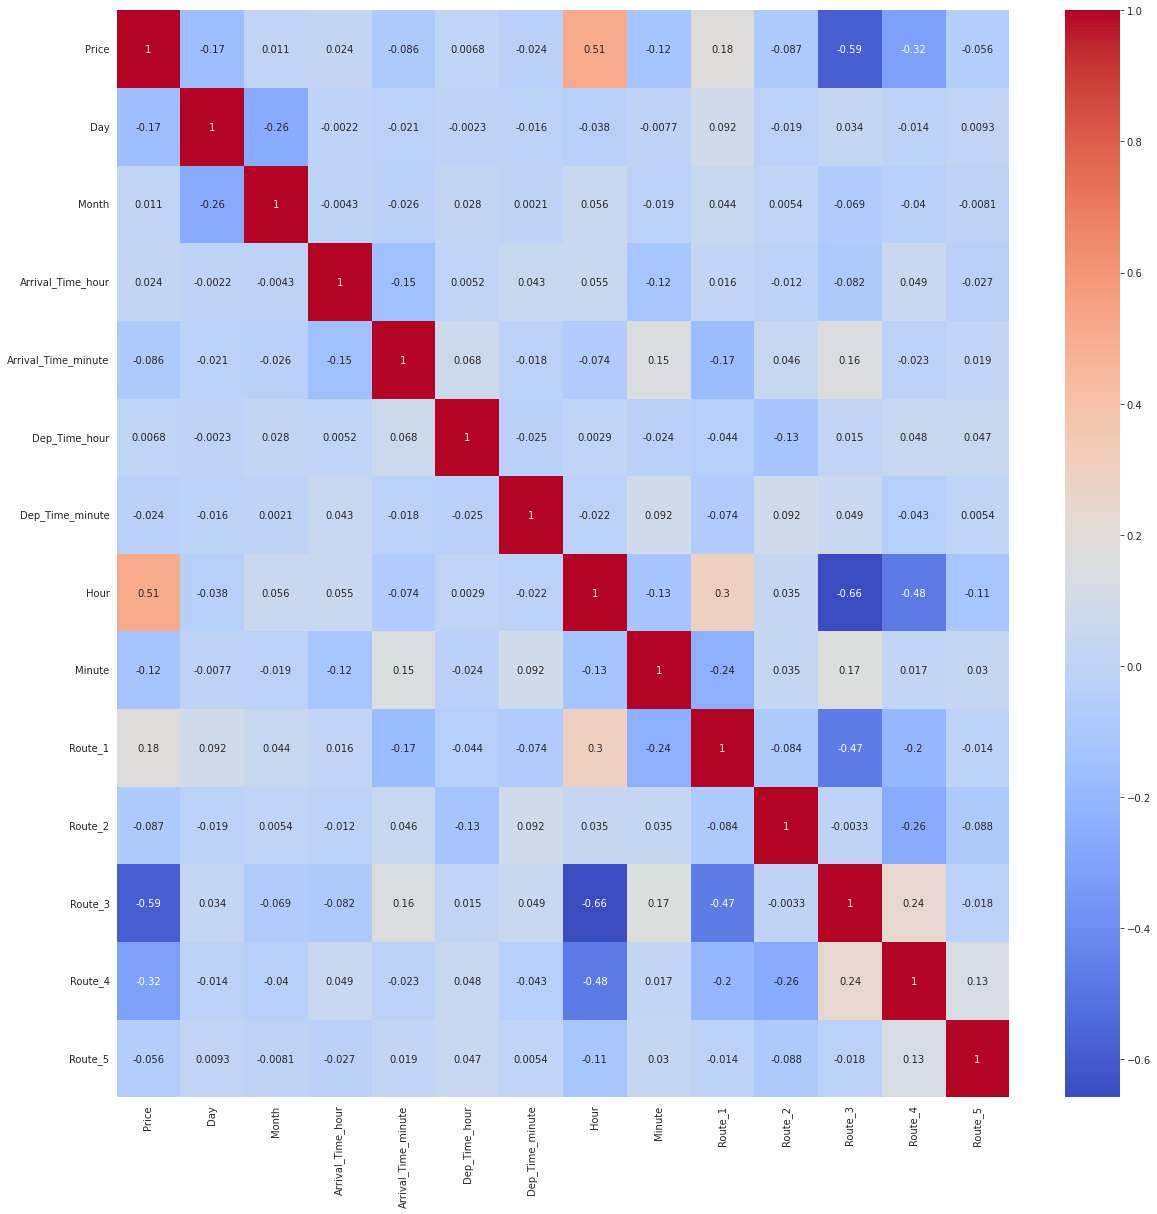

In [48]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show() 

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)

## Modelling
### 1. Multiple Linear Regression

In [50]:
#multiple linear regression
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
print("Train score:",regressor.score(x_train, y_train))
print("Test score:",regressor.score(x_test, y_test))


Train score: 0.7318933983608058
Test score: 0.732322574228929


### 2. Decision Tree Regression

In [51]:
from sklearn.tree import DecisionTreeRegressor
regressor=DecisionTreeRegressor(random_state=0)
regressor.fit(x_train, y_train)
y_pred=regressor.predict(x_test)
print("Train score:",regressor.score(x_train, y_train))
print("Test score:",regressor.score(x_test, y_test))

Train score: 0.9745044012402214
Test score: 0.7947476239584673


### 3. Random Forest Regressor

In [52]:
from sklearn.ensemble import RandomForestRegressor
regressor=RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(x_train, y_train)
y_pred=regressor.predict(x_test)
print("Train score:",regressor.score(x_train, y_train))
print("Test score:",regressor.score(x_test, y_test))

Train score: 0.9655229179930497
Test score: 0.8611379488127943


### We are getting the highest accuracy for random forest & Decision tree for testing dataset

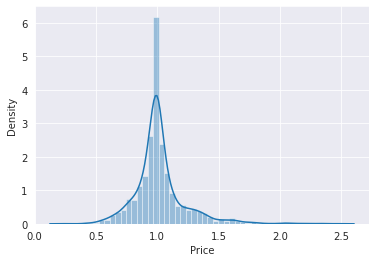

In [53]:
sns.distplot(np.exp(y_test- y_pred))
plt.show()

Text(0.5, 1.0, 'Result')

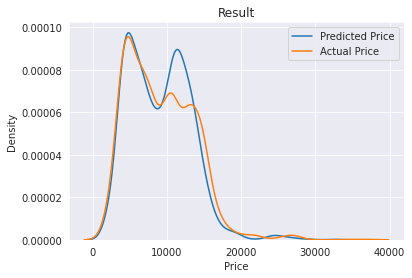

In [54]:
sns.kdeplot(np.exp(y_pred),label='Predicted Price')
sns.kdeplot(np.exp(y_test),label='Actual Price')
plt.legend()
plt.title('Result')

Text(0.5, 1.0, 'Actual/Predicted Price')

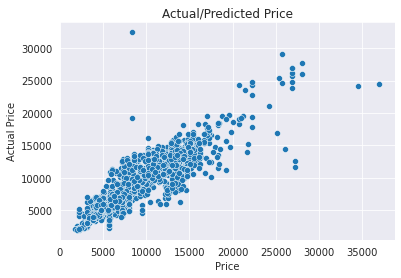

In [55]:
sns.scatterplot(x = np.exp(y_test),y = np.exp(y_pred))
plt.ylabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Actual/Predicted Price')

In [56]:
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred)
metrics.mean_squared_error(y_test, y_pred)
metrics.r2_score(y_test, y_pred)

0.8611379488127943

In [57]:
print(f'Training Score - {(regressor.score(x_train, y_train) * 100).round(2)}%')
print(f'Testing Score  - {(regressor.score(x_test, y_test) * 100).round(2)}%')

Training Score - 96.55%
Testing Score  - 86.11%


### Save the model

In [58]:
import pickle

file = open('flight_model.pkl', 'wb')
pickle.dump(regressor, file)
model=open('flight_model.pkl', 'rb')
flight_price=pickle.load(model)

### Saving our tested values in an excel file

In [59]:
import pandas as pd
csv = pd.DataFrame(np.exp(y_pred), columns=["Price"])
csv.to_csv("prediction.csv", index=False)

### Importing our model to use it on our test data file

In [68]:
import os 
import glob
import pandas as pd

x_test = test
model = './flight_model.pkl'

# load the model
load_model = pickle.load(open(model, 'rb'))
  
y_pred = load_model.predict(x_test)

csv = pd.DataFrame(np.exp(y_pred), columns=["Price"])
csv.to_csv("prediction.csv", index=False)
